# Entropy Analysis of the 4x3 lexicons for both the Ostensive Signalling and the Pragmatic Updating model.

Let's start with importing the packages we need to read in the data.

In [2]:
#imports
import os
import numpy as np
import pandas as pd

Let's create the mechanisms for reading in the existing data. The config file contains the configurations for this particular output file.

In [3]:
# config.csv:
# agentPairs;maxTurns;roundsPlayed;beta;entropyThreshold;
#  order;costs;initiatorDistribution;responderDistribution
def read_config(location, config_title):
    filename = location + "config" + config_title + ".csv"
    with open(filename) as f:
        config = pd.read_csv(filename, sep=";")
    return config

Next, we have the data that reports on the end result of each round of interaction, for all of the agents. This entails both the number of turns the agents use before they believe to understand each other, as well as whether they had success in their communication.

In [4]:
# results_rounds.csv: 
# pair;round;nrTurns;success
def read_results_rounds(location, config_title):
    filename = location + "results_rounds" + config_title + ".csv"
    with open(filename) as f:
        results_rounds = pd.read_csv(filename, sep=";")
    return results_rounds

Finally, for this set, we have the rest of the data. This is a lot larger, and contains all the information recorded throughout all interactions. So where the above contains only the results per round of interaction, this dataset contains all the information of what happens in each turn of the conversation.

In [5]:
# results_turns.csv: 
# pair;round;turn;initiatorIntention;initiatorSignal;
# responderInference;responderSignal;entropyInitiatorListen;entropyResponderListen;
# entropyInitiatorLexicon;entropyResponderLexicon;KLDivItoR;KLDivRtoI
def read_results_turns(location, config_title):
    filename = location + "results_turns" + config_title + ".csv"
    with open(filename) as f:
        results_turns = pd.read_csv(filename, sep=";")
    return results_turns

Some more imports, this time to allow graphs to be made.

In [6]:
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.stats as st
#import csv

Now to gather the specific data we need. Initially I will be testing this on one configuration only (though it should eventually also run on all other parameter settings). These are: The 4x3 lexicon size, binomial distribution with an X of 0.45 and 0.55, an alpha of 5, and 500 agents. This will of course be run for both the Ostensive Signalling model as well as the Pragmatic Updating model.

In [7]:
pragmatic_model_title = "_a500_b5.0_d0.45"
pragmatic_model_location = "s4-r3-lanagadaptive/"
pragmatic_save_location = "fig/4x3/entropy"

ostensive_model_title = "_exp_a500_b5.0_d0.45"
ostensive_model_location = "s4-r3-explicit/"
ostensive_save_location = "fig/4x3-explicit/entropy/"


We can now import all the necessary datasets. Currently only importing the one I need for the entropy analysis.

In [8]:
pragmatic_results_turns = read_results_turns(pragmatic_model_location, pragmatic_model_title)
ostensive_results_turns = read_results_turns(ostensive_model_location, ostensive_model_title)

The labelling of turns is off slightly because of how it was built, the below code fixes that (do not run it extra without reloading the data, else the +1 row will throw everything off)

In [9]:
for i, row in pragmatic_results_turns.iterrows():
    if row["turn"] == 0 and np.isnan(row["entropyInitiatorListen"]):
        pragmatic_results_turns.at[i,"turn"] = -1
pragmatic_results_turns["turn"] = [x+1 for x in pragmatic_results_turns["turn"]]

for i, row in ostensive_results_turns.iterrows():
    if row["turn"] == 0 and np.isnan(row["entropyInitiatorListen"]):
        ostensive_results_turns.at[i,"turn"] = -1
ostensive_results_turns["turn"] = [x+1 for x in ostensive_results_turns["turn"]]

Before we continue, we merge the results_rounds with the useful information from the results_turns. This way, while looking at a turns level, we still have access to the information on how long a conversation was, and its success.

In [10]:
pragmatic_results_rounds = read_results_rounds(pragmatic_model_location, pragmatic_model_title)
ostensive_results_rounds = read_results_rounds(ostensive_model_location, ostensive_model_title)

In [11]:
pragmatic_results_merged = pragmatic_results_rounds.merge(pragmatic_results_turns, left_on=['pair', 'round'], right_on=['pair', 'round'])
ostensive_results_merged = ostensive_results_rounds.merge(ostensive_results_turns, left_on=['pair', 'round'], right_on=['pair', 'round'])

Next, we will need to create the code that allows us to look only at what we wish to look at. The dataset we need comes from results_turns, which is rather large. What we will need is the pair (agentnumber), round, turn (all for keeping track of where in the conversation we are), and the entropyInitiatorListen and entropyResponderListen. Because all code from now on will run for any model we enter, these will be functions.

In [12]:
def entropy_agents(results_turns):
    entropy_results = results_turns.loc[:,['pair', 'round', 'nrTurns', 'success', 'turn', 'entropyInitiatorListen', 'entropyResponderListen']]
    return entropy_results

In [13]:
pragmatic_entropy_results = entropy_agents(pragmatic_results_merged)
ostensive_entropy_results = entropy_agents(ostensive_results_merged)
# print(pragmatic_entropy_results.head(20))
# print(ostensive_entropy_results.head(20))

In [14]:
# pragmatic_entropy_results = entropy_agents(pragmatic_results_turns, pragmatic_save_location)
# ostensive_entropy_results = entropy_agents(ostensive_results_turns, ostensive_save_location)

#new datasets where initiator and responder data is split, and nan-values are dropped.
pragmatic_initiators = pragmatic_entropy_results.loc[:,['pair', 'round', 'nrTurns', 'success','turn', 'entropyInitiatorListen']].dropna()
pragmatic_initiators.rename(columns = {'entropyInitiatorListen':'entropy'}, inplace = True)
pragmatic_responders = pragmatic_entropy_results.loc[:,['pair', 'round', 'nrTurns', 'success','turn', 'entropyResponderListen']].dropna()
pragmatic_responders.rename(columns = {'entropyResponderListen':'entropy'}, inplace = True)
ostensive_initiators = ostensive_entropy_results.loc[:,['pair', 'round', 'nrTurns', 'success','turn', 'entropyInitiatorListen']].dropna()
ostensive_initiators.rename(columns = {'entropyInitiatorListen':'entropy'}, inplace = True)
ostensive_responders = ostensive_entropy_results.loc[:,['pair', 'round', 'nrTurns', 'success','turn', 'entropyResponderListen']].dropna()
ostensive_responders.rename(columns = {'entropyResponderListen':'entropy'}, inplace = True)

The below images show the average entropy over rounds separatated out (per image) on ostension vs non-ostension, and initiator vs responder

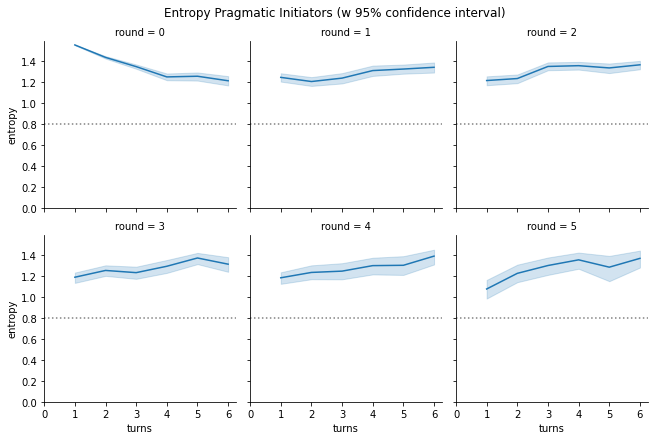

In [15]:
g = sns.FacetGrid(pragmatic_initiators, col="round", col_wrap=3, sharey=True, sharex=True)

g.map(sns.lineplot, "turn", "entropy")
g.map(plt.axhline, y=0.8, ls=":", c=".5")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Entropy Pragmatic Initiators (w 95% confidence interval)")
g.set(xticks=np.arange(7), ylim=(0, None),xlabel="turns", ylabel="entropy")


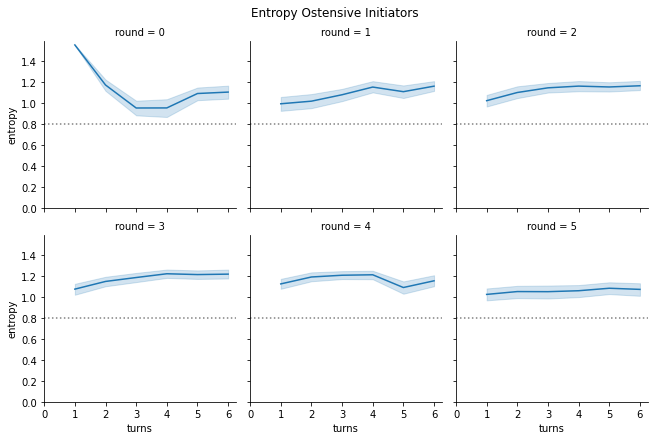

In [16]:
g = sns.FacetGrid(ostensive_initiators, col="round", col_wrap=3, sharey=True, sharex=True)

g.map(sns.lineplot, "turn", "entropy")
g.map(plt.axhline, y=0.8, ls=":", c=".5")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Entropy Ostensive Initiators")
g.set(xticks=np.arange(7), ylim=(0, None),xlabel="turns", ylabel="entropy")

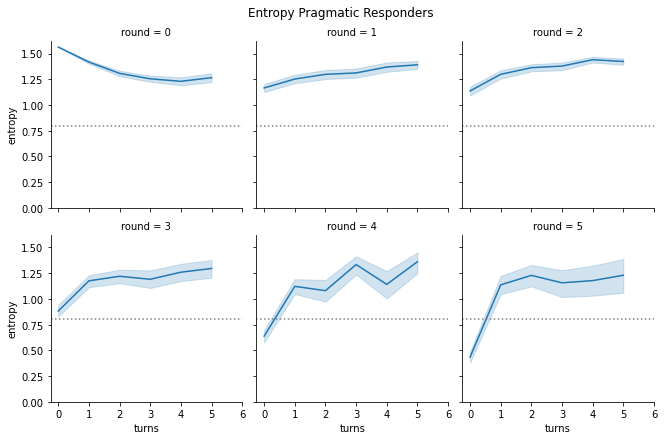

In [17]:
g = sns.FacetGrid(pragmatic_responders, col="round", col_wrap=3, sharey=True, sharex=True)

g.map(sns.lineplot, "turn", "entropy")
g.map(plt.axhline, y=0.8, ls=":", c=".5")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Entropy Pragmatic Responders")
g.set(xticks=np.arange(7), ylim=(0, None),xlabel="turns", ylabel="entropy")

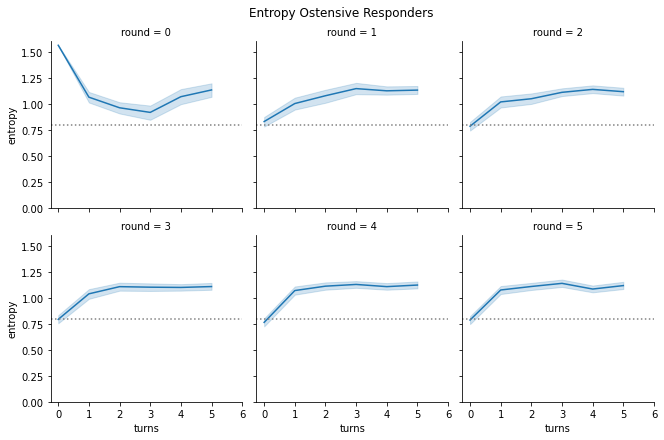

In [18]:
g = sns.FacetGrid(ostensive_responders, col="round", col_wrap=3, sharey=True, sharex=True)

g.map(sns.lineplot, "turn", "entropy")
g.map(plt.axhline, y=0.8, ls=":", c=".5")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Entropy Ostensive Responders")
g.set(xticks=np.arange(7), ylim=(0, None),xlabel="turns", ylabel="entropy")

The images below show the entropy over turns, coloured by number of turns that conversation took. So if an interaction ends after the first interaction, it is the lightest colour purple. If it takes one turn longer it is one shade darker (and the entropy lines also stop at that point), and so forth. The dotted line at 0.8 shows the threshold set for perceived understanding.

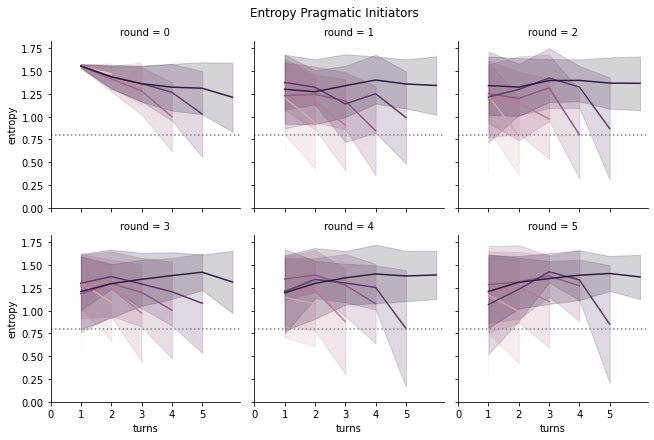

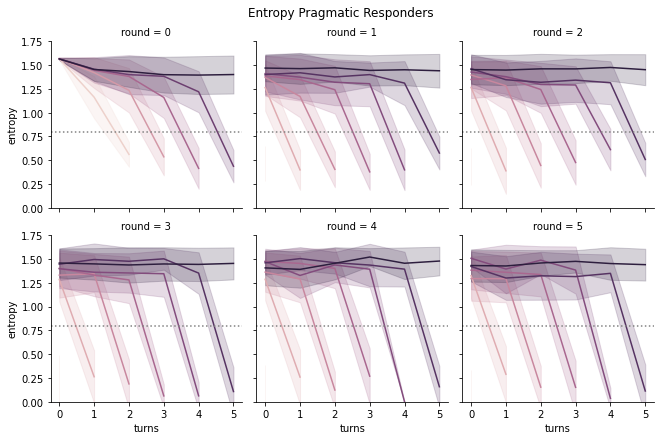

In [19]:
g = sns.FacetGrid(pragmatic_initiators, col="round", col_wrap=3, sharey=True, sharex=True)

g.map(sns.lineplot, "turn", "entropy", "nrTurns", ci='sd')
g.map(plt.axhline, y=0.8, ls=":", c=".5")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Entropy Pragmatic Initiators")
g.set(xticks=np.arange(6), ylim=(0, None),xlabel="turns", ylabel="entropy")

g = sns.FacetGrid(pragmatic_responders, col="round", col_wrap=3, sharey=True, sharex=True)

g.map(sns.lineplot, "turn", "entropy", "nrTurns", ci='sd')
g.map(plt.axhline, y=0.8, ls=":", c=".5")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Entropy Pragmatic Responders")
g.set(xticks=np.arange(6), ylim=(0, None),xlabel="turns", ylabel="entropy")

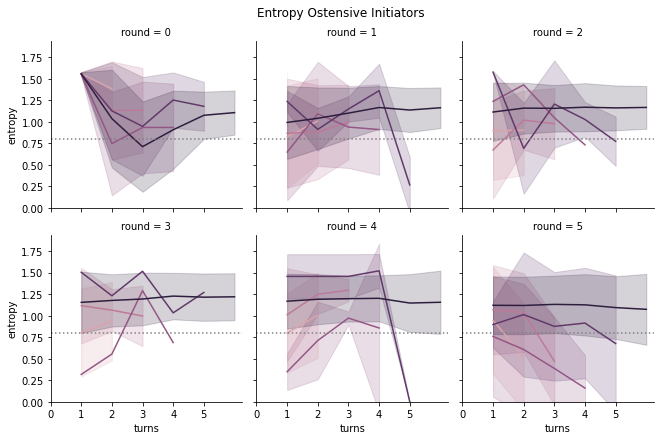

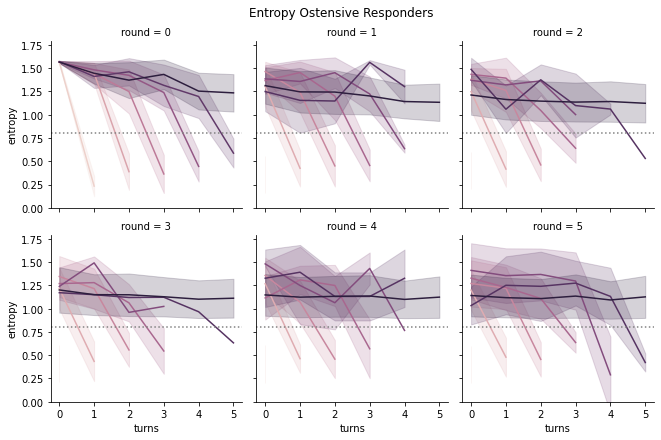

In [20]:
g = sns.FacetGrid(ostensive_initiators, col="round", col_wrap=3, sharey=True, sharex=True)

g.map(sns.lineplot, "turn", "entropy", "nrTurns", ci='sd')
g.map(plt.axhline, y=0.8, ls=":", c=".5")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Entropy Ostensive Initiators")
g.set(xticks=np.arange(6), ylim=(0, None),xlabel="turns", ylabel="entropy")

g = sns.FacetGrid(ostensive_responders, col="round", col_wrap=3, sharey=True, sharex=True)

g.map(sns.lineplot, "turn", "entropy", "nrTurns", ci='sd')
g.map(plt.axhline, y=0.8, ls=":", c=".5")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Entropy Ostensive Responders")
g.set(xticks=np.arange(6), ylim=(0, None),xlabel="turns", ylabel="entropy")

The images below show the factual understanding the agents have, dependent on the turn in which they decide to alter the conversation. (This is the first analysis, but shown in the same format as the other images here).

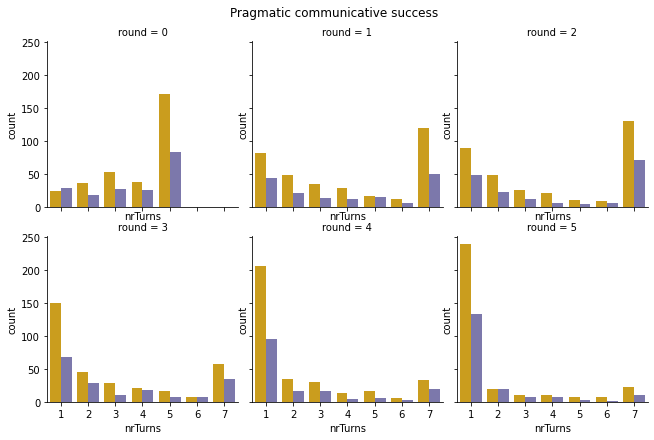

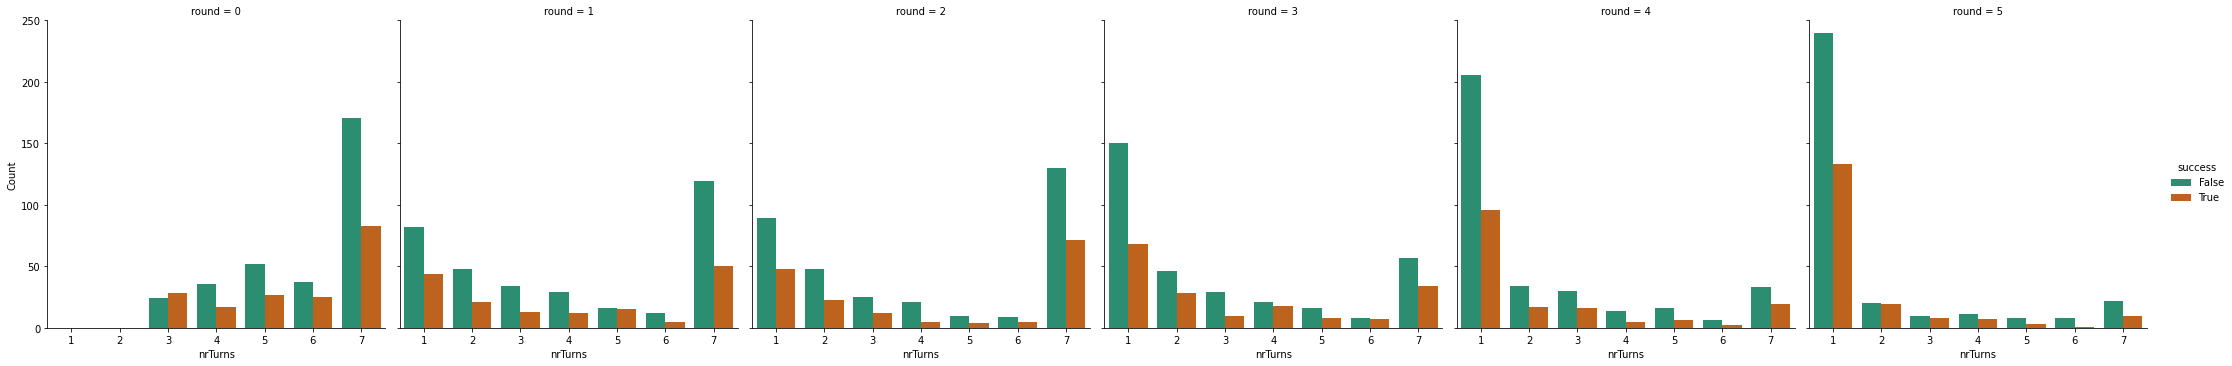

In [61]:
g = sns.FacetGrid(pragmatic_results_rounds, col="round", col_wrap=3, sharey=True, sharex=True)

g.map_dataframe(sns.countplot, x="nrTurns", hue="success", palette="Dark2_r")
# g.map_dataframe(sns.countplot, x="nrTurns", hue="success", palette="viridis_r")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Pragmatic communicative success")
g.set(xticks=np.arange(7), ylim=(0, None),xlabel="nrTurns", ylabel="count")

g.savefig("fig/analysis1/non-ost_analysis1.png")


f = sns.catplot(x="nrTurns", hue="success", col="round", data=pragmatic_results_rounds, kind="count", palette="Dark2")
(f.set_axis_labels("nrTurns", "Count")
  .set(ylim=(0, 250)))  
f.savefig("fig/analysis1/non-ost_analysis1_adjusted_c.pdf")

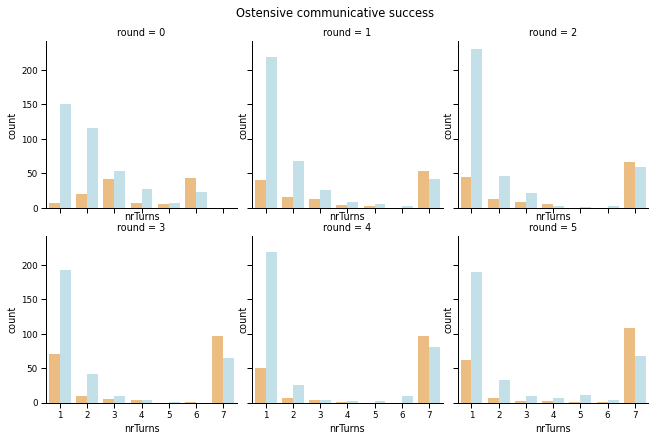

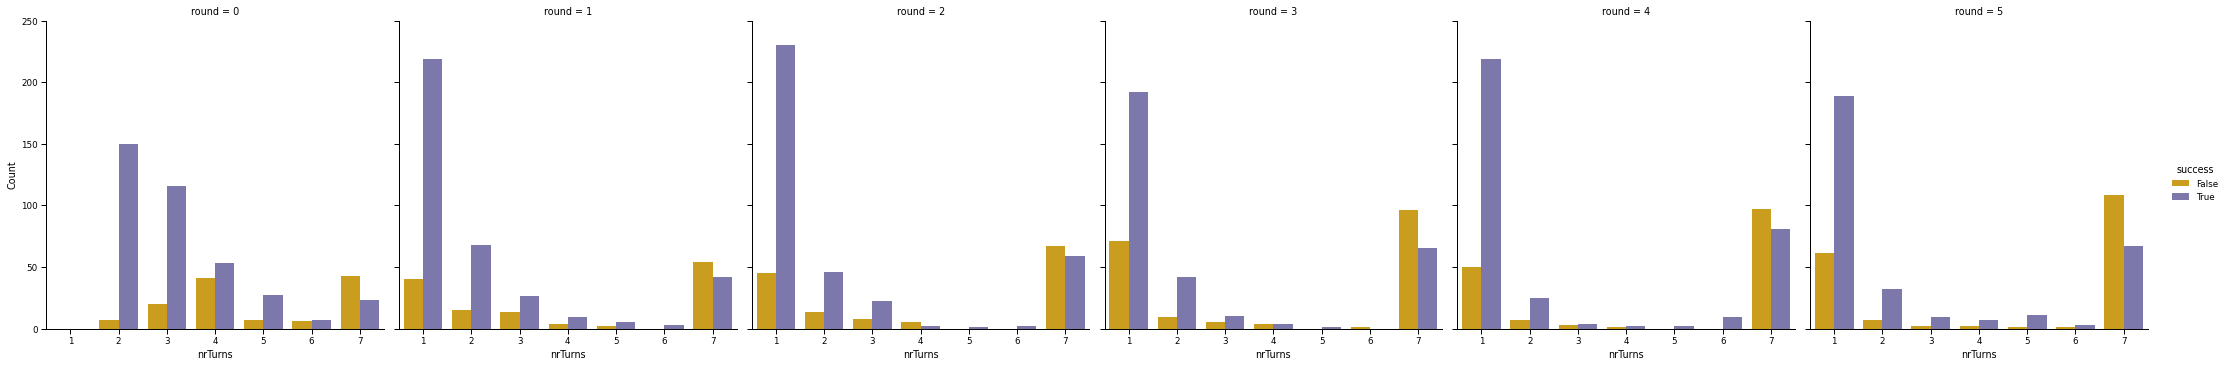

In [84]:
g = sns.FacetGrid(ostensive_results_rounds, col="round", col_wrap=3, sharey=True, sharex=True)

g.map_dataframe(sns.countplot, x="nrTurns", hue="success", palette="RdYlBu")
# g.map(plt.axhline, y=0.8, ls=":", c=".5")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Ostensive communicative success")
g.set(xticks=np.arange(7), ylim=(0, None),xlabel="nrTurns", ylabel="count")

g.savefig("fig/analysis1/ost_analysis1.png")


f = sns.catplot(x="nrTurns", hue="success", col="round", data=ostensive_results_rounds, kind="count", palette="Dark2_r")
(f.set_axis_labels("nrTurns", "Count")
  .set(ylim=(0, 250)))  
f.savefig("fig/analysis1/ost_analysis1_adjusted.pdf")

Below follow the information to create tables of factual vs perceived understanding

In [23]:
perceived_understanding_prag = pragmatic_results_rounds[pragmatic_results_rounds.nrTurns <= 6]
# print(perceived_understanding_prag.count())
perceived_misunderstanding_prag = pragmatic_results_rounds[pragmatic_results_rounds.nrTurns > 6]
# print(perceived_misunderstanding_prag.count())
print(perceived_understanding_prag[perceived_understanding_prag.success == True].count())
print(perceived_understanding_prag[perceived_understanding_prag.success == False].count())
print(perceived_misunderstanding_prag[perceived_misunderstanding_prag.success == True].count())
print(perceived_misunderstanding_prag[perceived_misunderstanding_prag.success == False].count())

pair       756
round      756
nrTurns    756
success    756
dtype: int64
pair       1445
round      1445
nrTurns    1445
success    1445
dtype: int64
pair       267
round      267
nrTurns    267
success    267
dtype: int64
pair       532
round      532
nrTurns    532
success    532
dtype: int64


| Non-Ostensive ||| Perceived yes | Perceived no  |
| ------------- ||| -------------:|-------------: |
| factual yes   ||| 756           | 267           |
| factual no    ||| 1445          |   532         |



And for the ostensive case

In [24]:
perceived_understanding_ost = ostensive_results_rounds[ostensive_results_rounds.nrTurns <= 6]
# print(perceived_understanding_ost.count())
perceived_misunderstanding_ost = ostensive_results_rounds[ostensive_results_rounds.nrTurns > 6]
# print(perceived_misunderstanding_ost.count())
print(perceived_understanding_ost[perceived_understanding_ost.success == True].count())
print(perceived_understanding_ost[perceived_understanding_ost.success == False].count())
print(perceived_misunderstanding_ost[perceived_misunderstanding_ost.success == True].count())
print(perceived_misunderstanding_ost[perceived_misunderstanding_ost.success == False].count())

pair       1747
round      1747
nrTurns    1747
success    1747
dtype: int64
pair       451
round      451
nrTurns    451
success    451
dtype: int64
pair       337
round      337
nrTurns    337
success    337
dtype: int64
pair       465
round      465
nrTurns    465
success    465
dtype: int64


| Ostensive     ||| Perceived yes | Perceived no  |
| ------------- ||| -------------:|-------------: |
| factual yes   ||| 1747          | 337           |
| factual no    ||| 451           |   465         |

|Per round   ||| Initiator end | Responder end | Give Up |
|----------- ||| ------------: | -------------:| -------:|
|factual yes |||               |               |         |
|factual no  |||               |               |         |

In [25]:
# pragmatic_results_rounds.head(10)
pragmatic_results_merged.head(10)

,pair,round,nrTurns,success,turn,initiatorIntention,initiatorSignal,responderInference,responderSignal,entropyInitiatorListen,entropyResponderListen,entropyInitiatorLexicon,entropyResponderLexicon,KLDivItoR,KLDivRtoI
0,0,0,6,True,0,R2,S3,R3,S3,NaN,1.570786,6.578251,6.578251,43.343688,43.343688
1,0,0,6,True,1,R2,S2,R1,S4,1.575610,1.419180,6.578251,4.967858,46.693005,44.485770
2,0,0,6,True,2,R2,S4,R2,S1,1.475462,1.539227,5.210865,4.037726,37.294019,41.299798
3,0,0,6,True,3,R2,S1,R2,S4,1.540725,1.576769,3.318957,4.173103,14.575448,40.883178
4,0,0,6,True,4,R2,S1,R2,S4,1.160323,1.578229,2.646598,3.103917,40.655288,38.661512
5,0,0,6,True,5,R2,I understand,NaN,NaN,0.422335,NaN,0.775029,NaN,NaN,NaN
6,0,1,7,False,0,R3,S3,R1,S4,NaN,1.538025,0.775029,2.925161,39.224427,37.916213
7,0,1,7,False,1,R3,S4,R2,S4,0.422335,1.502196,0.775029,2.470719,2.199872,37.545240
8,0,1,7,False,2,R3,S3,R1,S3,1.529505,1.429056,3.032382,2.311724,35.447480,40.808241
9,0,1,7,False,3,R3,S1,R3,S1,1.567412,1.501996,2.339901,2.465634,37.638054,27.380866


In [26]:
pragmatic_results_endings = pragmatic_results_rounds
ostensive_results_endings = ostensive_results_rounds

def intention_ender(results_merged, results_rounds):
    endings = []
    for agent in range(0,500):
        agent_block_merged = results_merged.loc[results_merged['pair'] == agent]
        agent_block_rounds = results_rounds.loc[results_rounds['pair'] == agent]
        for intention in range(0,6):
            nrTurn = agent_block_rounds.iloc[intention]['nrTurns']
            intention_block = agent_block_merged.loc[agent_block_merged['round'] == intention]
#             print(intention_block)
            if nrTurn == 7:
                endings.append("Give up")
            elif intention_block.iloc[nrTurn-1].at['initiatorSignal'] == "I understand":
                endings.append("Initiator")
            elif intention_block.iloc[nrTurn-1].at['responderSignal'] == "I understand":
                endings.append("Responder")
    return endings

ending_pragmatic = intention_ender(pragmatic_results_merged, pragmatic_results_rounds)
pragmatic_results_endings['endReason'] = ending_pragmatic

ending_ostensive = intention_ender(ostensive_results_merged, ostensive_results_rounds)
ostensive_results_endings['endReason'] = ending_ostensive

In [27]:
pragmatic_results_endings.head(20)
# ostensive_results_endings.head(20)

,pair,round,nrTurns,success,endReason
0,0,0,6,True,Initiator
1,0,1,7,False,Give up
2,0,2,7,False,Give up
3,0,3,2,False,Responder
4,0,4,1,True,Responder
5,0,5,1,False,Responder
6,1,0,7,False,Give up
7,1,1,5,True,Initiator
8,1,2,3,False,Initiator
9,1,3,5,False,Initiator


In [28]:
trues_prag = pragmatic_results_rounds[pragmatic_results_rounds['success'] == True]
falses_prag = pragmatic_results_rounds[pragmatic_results_rounds['success'] == False]
temp_true_prag = trues_prag.groupby(["round", "nrTurns"]).count()
temp_false_prag = falses_prag.groupby(["round", "nrTurns"]).count()
# temp1 = temp[temp["success"] == True]
# temp2 = temp[temp["success"] == False]
# ax = sns.countplot(x="round", hue="endReason", data = pragmatic_results_endings)
# ax.set_title("Non-ostensive")
# print(temp_true_prag)
# print(temp_false_prag)

temp3 = pd.merge(temp_true_prag, temp_false_prag, left_on=["round", "nrTurns"], right_on=["round", "nrTurns"])
temp3["ratio"] = temp3["pair_x"] - temp3["pair_y"]
temp3 = temp3.loc[:,['pair_x', 'pair_y', 'ratio']]

# temp3.drop(index=["round", "nrTurns"], inplace=True)
temp3.reset_index(inplace=True)
print(temp3)

    round  nrTurns  pair_x  pair_y  ratio
0       0        3      28      24      4
1       0        4      17      36    -19
2       0        5      27      52    -25
3       0        6      25      37    -12
4       0        7      83     171    -88
5       1        1      44      82    -38
6       1        2      21      48    -27
7       1        3      13      34    -21
8       1        4      12      29    -17
9       1        5      15      16     -1
10      1        6       5      12     -7
11      1        7      50     119    -69
12      2        1      48      89    -41
13      2        2      23      48    -25
14      2        3      12      25    -13
15      2        4       5      21    -16
16      2        5       4      10     -6
17      2        6       5       9     -4
18      2        7      71     130    -59
19      3        1      68     150    -82
20      3        2      28      46    -18
21      3        3      10      29    -19
22      3        4      18      21

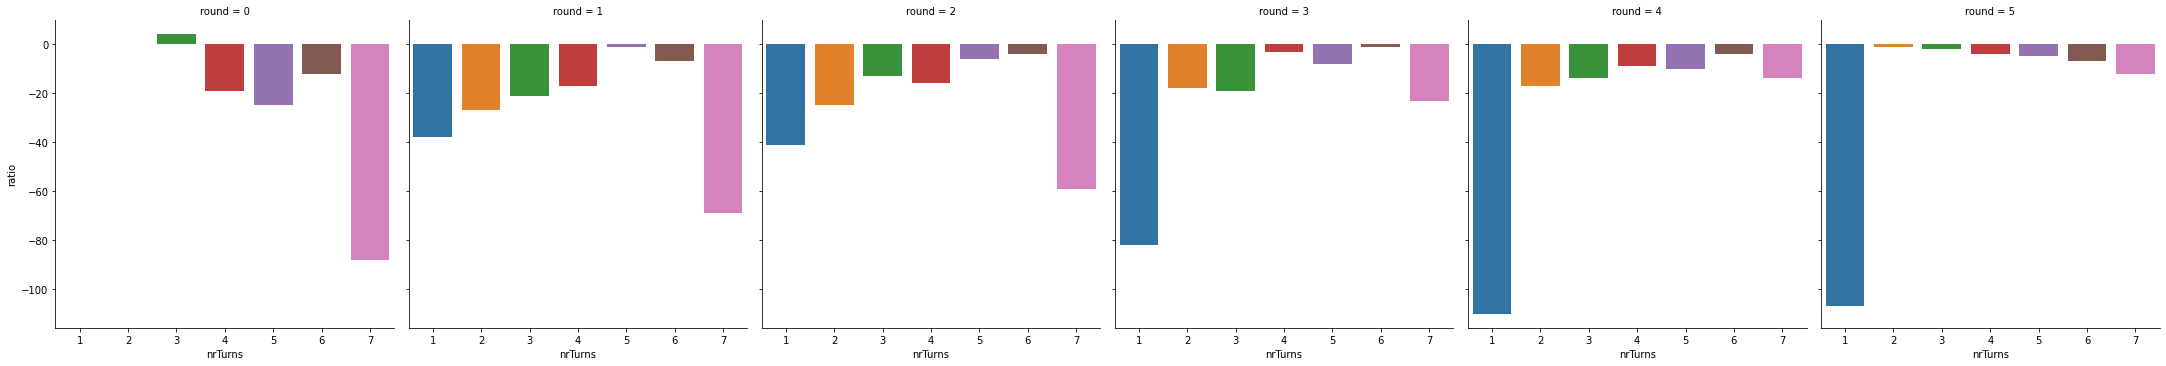

In [29]:
ax = sns.catplot(x="nrTurns", y="ratio" , col="round", data = temp3, kind="bar")



In [30]:
trues_ost = ostensive_results_rounds[ostensive_results_rounds['success'] == True]
falses_ost = ostensive_results_rounds[ostensive_results_rounds['success'] == False]
temp_true_ost = trues_ost.groupby(["round", "nrTurns"]).count()
temp_false_ost = falses_ost.groupby(["round", "nrTurns"]).count()

temp4 = pd.merge(temp_true_ost, temp_false_ost, left_on=["round", "nrTurns"], right_on=["round", "nrTurns"])
temp4["ratio"] = temp4["pair_x"] - temp4["pair_y"]
temp4 = temp4.loc[:,['pair_x', 'pair_y', 'ratio']]

temp4.reset_index(inplace=True)


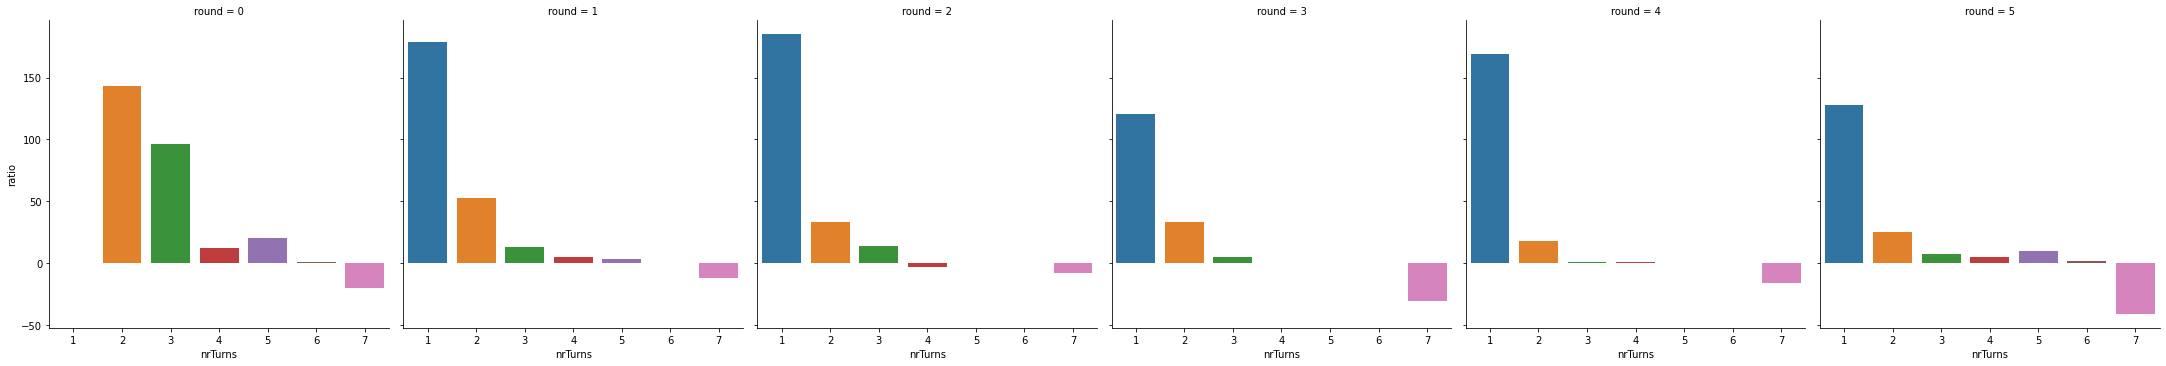

In [31]:
ax = sns.catplot(x="nrTurns", y="ratio" , col="round", data = temp4, kind="bar")

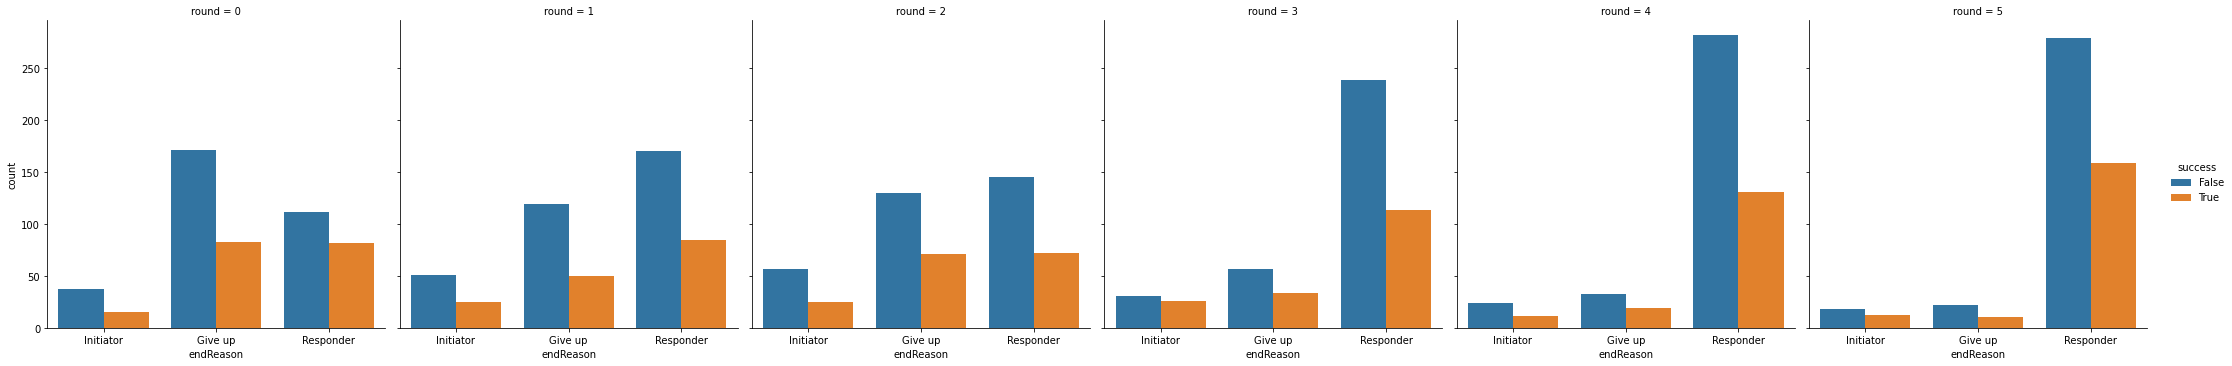

In [32]:
ax = sns.catplot(x="endReason", hue="success", col="round", data=pragmatic_results_endings, kind="count");
# ax.set_suptitle("Non-ostensive factual success and who ends the conversation")
# ax.set_xLabel("Factual Understanding")

Text(0.5, 1.0, 'Ostensive')

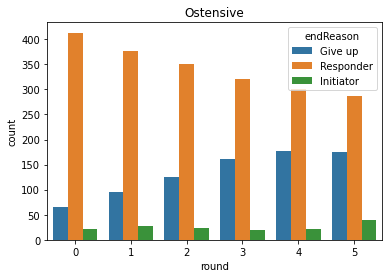

In [33]:
ax = sns.countplot(x="round", hue="endReason", data = ostensive_results_endings)
ax.set_title("Ostensive")

Some remaking of images: figure 3, the decrease in turn length over rounds played

In [35]:
pragmatic_results_rounds.head(20)

,pair,round,nrTurns,success,endReason
0,0,0,6,True,Initiator
1,0,1,7,False,Give up
2,0,2,7,False,Give up
3,0,3,2,False,Responder
4,0,4,1,True,Responder
5,0,5,1,False,Responder
6,1,0,7,False,Give up
7,1,1,5,True,Initiator
8,1,2,3,False,Initiator
9,1,3,5,False,Initiator


<ipython-input-70-c8624c04cefc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_pragmatic["model"] = 'Non-Ostensive'
<ipython-input-70-c8624c04cefc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_ostensive["model"] = 'Ostensive'


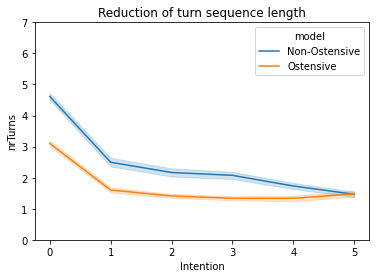

In [70]:

sub_pragmatic = pragmatic_results_rounds.loc[pragmatic_results_rounds['nrTurns'] < 7]
sub_pragmatic["model"] = 'Non-Ostensive'
sub_ostensive = ostensive_results_rounds.loc[ostensive_results_rounds['nrTurns'] < 7]
sub_ostensive["model"] = 'Ostensive'
mixed_results_rounds = pd.concat([sub_pragmatic, sub_ostensive]) 


f = sns.lineplot(data=mixed_results_rounds, x="round", y="nrTurns", hue="model", ci=90)
f.set_ylim([0,7])
f.set_xlabel("Intention")
f.set_title("Reduction of turn sequence length")
f.figure.savefig("fig/analysis0/turn_length_ci_90.pdf")

# sub_rounds = results_rounds.loc[:,['round', 'nrTurns']]
# sub_rounds_2 = sub_rounds.loc[sub_rounds['nrTurns'] < 7]
# grouped = sub_rounds_2.groupby('round')
# x = [0,1,2,3,4,5]
# average_success_over_turns = grouped['nrTurns'].agg(np.nanmean)
# std_succes_over_turns = grouped['nrTurns'].agg(np.nanstd)


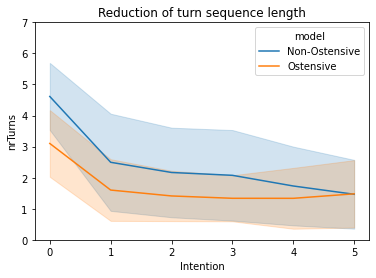

In [69]:
c = sns.lineplot(data=mixed_results_rounds, x="round", y="nrTurns", hue="model", ci='sd')
c.set_ylim([0,7])
c.set_xlabel("Intention")
c.set_title("Reduction of turn sequence length")
c.figure.savefig("fig/analysis0/turn_length_sd.pdf")

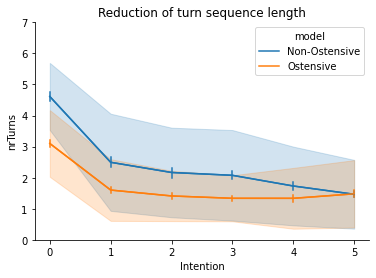

In [82]:
f = sns.lineplot(data=mixed_results_rounds, x="round", y="nrTurns", hue="model", err_style="bars")
c = sns.lineplot(data=mixed_results_rounds, x="round", y="nrTurns", hue="model", ci='sd', legend=False)
sns.despine()
f.set_ylim([0,7])
f.set_xlabel("Intention")
f.set_title("Reduction of turn sequence length")

f.figure.savefig("fig/analysis0/turn_length_mixed.pdf")